# Prediction on any song in the Database with prelearned XG-Boost

In [27]:
# Import Libraries:
import pandas as pd
import numpy as np
import librosa
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost

In [70]:
def get_genre_dict():
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    my_dict = dict(zip(range(len(genres)),genres)) # Create Dictionary to map genres to numbers of the algorithm
    return my_dict

# Insert Filename and Directory here:

In [6]:
# filename = 'genres_original/jazz/jazz.00027.wav' #for files from GTZAN
#filename = 'Bruce Springsteen - 06 - Empty Sky.mp3' # for files from Data
#filename = 'Christina Aguilera - 11 - Beautiful .mp3'
#filename = 'Kylie Minogue - Fever - 04 - Fever.mp3'
#filename = 'nelly furtado - powerless.mp3'
#filename = 'atomic_kitten-ladies_night.mp3'
#filename = 'Linkin Park - Points Of Authority(jay_gordon_remix).mp3'

filename = 'Red Hot Chili Peppers - By The Way.mp3'
filedir = '../Data/'

## Feature Extraction of the Song

In [13]:
# Extract Features and saves as dataframe

def extract_extern(filedir,filename):
    offset = 0
    duration=3
    go = True
    i=0
    csv = []
    length = 0
    length_audio = librosa.get_duration(filename = filedir+filename)
    offset = length_audio/4
    end = length_audio*3/4
    
    while(go):
        y, sr = librosa.load(filedir+filename, offset=offset, duration=duration)
        if (length != len(y) and length !=0) or (offset + duration) >= end:
            i=0
            break
        length = len(y)
        offset += duration
        
        #________ chroma_stft _______
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_stft_mean = np.mean(chroma_stft)
        chroma_stft_var = np.var(chroma_stft)
        #______rms _____
        rms =  librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        #______spectral_centroid _____
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid)
        spectral_centroid_var = np.var(spectral_centroid)
        #______spectral_bandwidth______
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        spectral_bandwidth_var = np.var(spectral_bandwidth)
        #_____rolloff_______
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)
        #_____zero_crossing_rate______
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        zero_crossing_rate_mean = np.mean(zero_crossing_rate)
        zero_crossing_rate_var = np.var(zero_crossing_rate)
        #_____harmony_____
        harmony = librosa.effects.harmonic(y)
        harmony_mean = np.mean(harmony)
        harmony_var = np.var(harmony)
        #_____perceptr____
        C = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('A1')))
        freqs = librosa.cqt_frequencies(C.shape[0], fmin=librosa.note_to_hz('A1'))
        perceptr = librosa.perceptual_weighting(C**2, freqs, ref=np.max)
        perceptr_mean = np.mean(perceptr)
        perceptr_var = np.var(perceptr)
        #_____tempo______
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        #_____mfcc______
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        mdict = {"name":filename,
                "name_v":filename+"."+str(i),
                "filedir":filedir,
                "start":offset-duration,
                "length":length,
                "chroma_stft_mean" : chroma_stft_mean,
                "chroma_stft_var":chroma_stft_var,
                "rms_mean": rms_mean,
                "rms_var":rms_var,
                "spectral_centroid_mean": spectral_centroid_mean,
                "spectral_centroid_var" : spectral_centroid_var,
                "spectral_bandwidth_mean":spectral_bandwidth_mean,
                "spectral_bandwidth_var": spectral_bandwidth_var, 
                "rolloff_mean" : rolloff_mean,
                "rolloff_var": rolloff_var ,
                "zero_crossing_rate_mean" : zero_crossing_rate_mean,
                "zero_crossing_rate_var":zero_crossing_rate_var,
                "harmony_mean":harmony_mean,
                "harmony_var":harmony_var,
                "perceptr_mean":perceptr_mean,
                "perceptr_var":perceptr_var,
                "tempo":tempo,}
        
        for index, a in enumerate(mfcc, start = 1):
            mdict["mfcc"+str(index)+"_mean"] = np.mean(a)
            mdict["mfcc"+str(index)+"_var"] = np.var(a)
            
        csv.append(mdict)
        i+=1
    return csv
    


In [20]:
def extract_and_save(filedir,filename):
    df = pd.DataFrame(extract_extern(filedir,filename))
    df.to_csv("features_last_song.csv")

In [21]:
extract_and_save(filedir,filename)

In [25]:
# Load XGBoost Model
def predict_last(features_csv): 
    xgb = xgboost.XGBClassifier()
    xgb.load_model("../Trained_Models/xgb_model.txt")
    df = pd.read_csv(features_csv)
    data = df.iloc[0:, 5:]
    preds = xgb.predict(data) # Make Prediction
    proba= xgb.predict_proba(data) #get Probabilities
    return preds,proba

In [77]:

def pred_time_series():
# Sort time and prediction
    preds,proba = predict_last("features_last_song.csv")
    df = pd.read_csv("features_last_song.csv")
    start = df['start'] # Get start time from dataframe
    my_dict = get_genre_dict()
    genres = my_dict.values()
# Remove Predictions where the probability is less than then setted percentage
    percentage = 0.50
    i=1
    list=[]
    while i<len(preds):
        if proba[i][proba[i].argmax()]<percentage:
            list.append(i)
        i +=1
# Delete the elements and resize the list
    proba=np.delete(proba,list, axis=0)
    preds=np.delete(preds,list, axis=0)
    start=start.drop(list)

# Plot the genres to the time series of the start times !!Attention: Plot does not show empty points!!
    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)
    plt.xlabel("Time [min]")
    plt.ylabel("Genres")
    prediction_label=[]
    for i in range(len(preds)):
        prediction_label.append(my_dict[preds[i]])
    time = pd.to_datetime(start, unit='s').dt.strftime('%M:%S')
    plt.xticks(rotation=-45)
    ax.scatter(time, prediction_label, linewidth=2.0)
    plt.show()

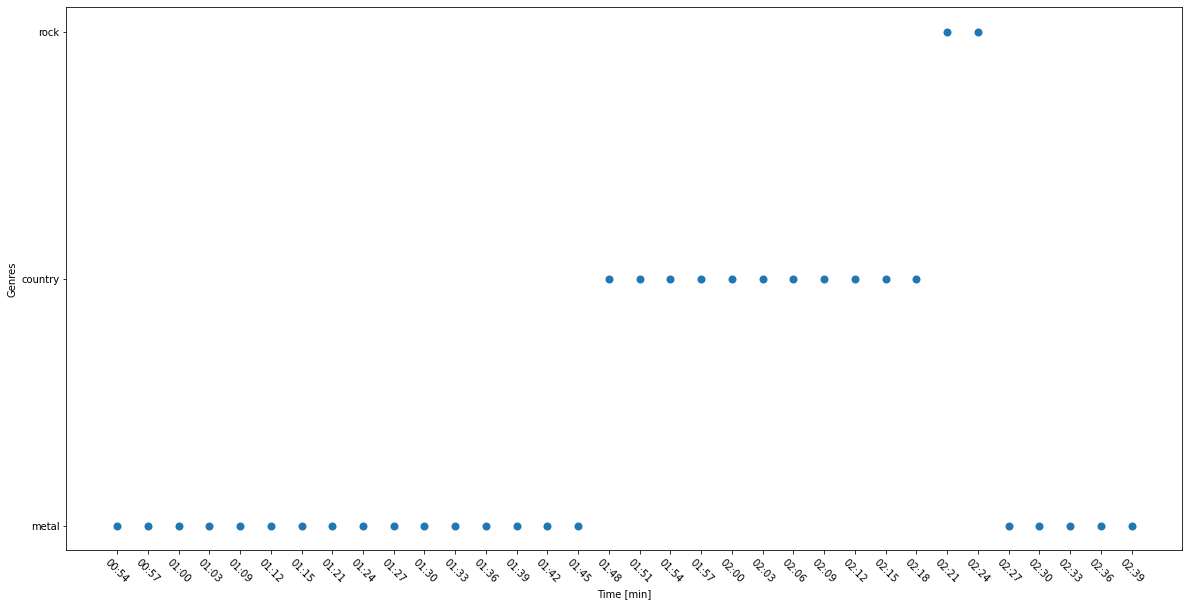

In [78]:
pred_time_series()

In [79]:
# Show the Probabilities of every prediction (two main classes):
def get_first_preds_proba(no_proba):
    preds_small = ""
    my_dict = get_genre_dict()
    genres = my_dict.values()
    preds,proba = predict_last("features_last_song.csv")
    for i in range(len(preds)):
        preds_small += "Prediction "+ str(i) +": " + my_dict[preds[i]] + " with Probabilities: "
        first = proba[i].argmax()
        temp = proba[i].copy()
        temp[first] = 0
        second = temp.argmax()
        preds_small += str(round(proba[i][first]*100,1)) + "% (" + my_dict[first] + ")"
        if no_proba == 2:
            preds_small += ", " + str(round(proba[i][second]*100,1)) + "% (" + my_dict[second] + ")\n"
        else:
             preds_small += "\n"
    return preds_small

In [80]:
print(get_first_preds_proba(2))

Prediction 0: metal with Probabilities: 96.5% (metal), 2.2% (rock)
Prediction 1: metal with Probabilities: 52.1% (metal), 43.1% (rock)
Prediction 2: metal with Probabilities: 91.4% (metal), 8.0% (rock)
Prediction 3: metal with Probabilities: 86.5% (metal), 7.8% (disco)
Prediction 4: disco with Probabilities: 35.5% (disco), 23.1% (country)
Prediction 5: metal with Probabilities: 59.9% (metal), 34.8% (country)
Prediction 6: metal with Probabilities: 60.7% (metal), 20.7% (country)
Prediction 7: metal with Probabilities: 98.9% (metal), 0.6% (rock)
Prediction 8: disco with Probabilities: 44.7% (disco), 17.3% (pop)
Prediction 9: metal with Probabilities: 53.7% (metal), 28.5% (rock)
Prediction 10: metal with Probabilities: 73.3% (metal), 12.8% (rock)
Prediction 11: metal with Probabilities: 93.9% (metal), 5.8% (rock)
Prediction 12: metal with Probabilities: 59.7% (metal), 27.8% (rock)
Prediction 13: metal with Probabilities: 96.8% (metal), 2.9% (rock)
Prediction 14: metal with Probabilities: 

In [97]:
# Show the Probabilities of every prediction (all classes):
def get_preds_all_proba():
    my_dict = get_genre_dict()
    temp = ""
    temp += str(my_dict.values()) +"\n"
    preds,proba = predict_last("features_last_song.csv")
    for i in range(len(preds)):
        temp += "Prediction " + str(i) + ": " + my_dict[preds[i]] + " with Probabilities: "
        for k in range(len(proba[i])):
            temp += str(round(proba[i][k]*100,1)) + "%, "
        temp += "\n"
    return temp

In [98]:
print(get_preds_all_proba())

dict_values(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
Prediction 0: metal with Probabilities: 0.0%, 0.0%, 0.1%, 0.6%, 0.5%, 0.0%, 96.5%, 0.0%, 0.0%, 2.2%, 
Prediction 1: metal with Probabilities: 0.7%, 0.0%, 0.3%, 2.6%, 0.7%, 0.0%, 52.1%, 0.3%, 0.3%, 43.1%, 
Prediction 2: metal with Probabilities: 0.0%, 0.0%, 0.2%, 0.2%, 0.1%, 0.0%, 91.4%, 0.0%, 0.0%, 8.0%, 
Prediction 3: metal with Probabilities: 0.4%, 0.0%, 2.3%, 7.8%, 0.2%, 0.0%, 86.5%, 0.0%, 0.1%, 2.7%, 
Prediction 4: disco with Probabilities: 11.1%, 0.2%, 23.1%, 35.5%, 0.1%, 0.1%, 16.9%, 0.1%, 0.2%, 12.6%, 
Prediction 5: metal with Probabilities: 0.8%, 0.0%, 34.8%, 2.8%, 0.1%, 0.0%, 59.9%, 0.1%, 0.1%, 1.4%, 
Prediction 6: metal with Probabilities: 1.1%, 0.2%, 20.7%, 12.3%, 0.8%, 0.1%, 60.7%, 0.3%, 0.2%, 3.6%, 
Prediction 7: metal with Probabilities: 0.1%, 0.0%, 0.2%, 0.2%, 0.0%, 0.0%, 98.9%, 0.0%, 0.0%, 0.6%, 
Prediction 8: disco with Probabilities: 0.4%, 0.0%, 13.3%, 44.7%, 0.

In [206]:
# Not ready: Should be the mean of every probability in every bin (so average proba over all metal predictions)
def avg_algorithm_probability():
    preds, proba = predict_last("features_last_song.csv")
    my_dict = get_genre_dict()
    av_proba = np.zeros(len(my_dict.values()), dtype=float)
    laenge=np.zeros(len(my_dict.values()), dtype=int)
    threshold = 0.5
    string = "Average Probability of Algorithm Prediction which where over " + str(threshold*100) + " % \n"
    for genre in range(len(my_dict.values())):
        for prob in range(len(proba)):
            if proba[prob][genre] > threshold:
                av_proba[genre] += proba[prob][genre]
                laenge[genre] += 1
            if prob == len(proba)-1 and laenge[genre] > 0:
                av_proba[genre] = av_proba[genre]/laenge[genre]
                string +=  my_dict[genre] + ": " + str(np.round(av_proba[genre]*100,1)) + " % \n"
        
    return string


In [207]:
print(avg_algorithm_probability())

Average Probability of Algorithm Prediction which where over 50.0 % 
country: 95.9 % 
metal: 84.1 % 
rock: 73.9 % 



In [210]:
# Print Binned Statistics
def get_binned_static():
    text =""
    preds, proba = predict_last("features_last_song.csv")
    my_dict = get_genre_dict()
    average_proba=[]
    text += repr(len(preds))+" single predictions found. Here are the Predictions grouped by Genres: \n"
    
    # Print all predictions binned on the gernes
    for i in range(len(my_dict)):
        if i<len(np.bincount(preds)):
            text = text + my_dict[i] + ": " + repr(np.bincount(preds)[i]) +" (" + repr(round(np.bincount(preds)[i]/len(preds)*100,1)) +"%) \n" 

    
    # Use the frequent value as main prediction:
    prediction=my_dict[np.bincount(preds).argmax()]
    text += "The most predicted genre is " + prediction + " (" + repr(round(np.bincount(preds)[np.bincount(preds).argmax()]/len(preds)*100,1)) + "% of the samples)" 
    return text

In [211]:
print(get_binned_static())

36 single predictions found. Here are the Predictions grouped by Genres: 
blues: 0 (0.0%) 
classical: 0 (0.0%) 
country: 11 (30.6%) 
disco: 2 (5.6%) 
hiphop: 0 (0.0%) 
jazz: 0 (0.0%) 
metal: 21 (58.3%) 
pop: 0 (0.0%) 
reggae: 0 (0.0%) 
rock: 2 (5.6%) 
The most predicted genre is metal (58.3% of the samples)
